# Se importan las bibliotecas necesarias

In [1]:
import pandas as pd
import re
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from catboost import CatBoostClassifier
%matplotlib inline

# Se lee el .csv

In [2]:
train = pd.read_csv('csv/train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test = pd.read_csv('csv/test.csv')

In [5]:
word2vec_score = pd.read_csv('csv/solo_embedding_word2vec_train.csv', usecols=['word2vec_score'])
word2vec_score.head()

,word2vec_score
0,0.570197
1,0.619319
2,0.665430
3,0.754068
4,0.643359


In [6]:
word2vec_score_test = pd.read_csv('csv/solo_embedding_word2vec_test.csv', usecols=['word2vec_score'])
word2vec_score_test.head()

,word2vec_score
0,0.546063
1,0.513793
2,0.560202
3,0.591379
4,0.670884


In [7]:
elmo_score = pd.read_csv('csv/solo_embedding_elmo_train.csv', usecols=['elmo_score'])
elmo_score.head()

,elmo_score
0,0.555488
1,0.602315
2,0.589332
3,0.623855
4,0.677215


In [8]:
elmo_score_test = pd.read_csv('csv/solo_embedding_elmo_test.csv', usecols=['elmo_score'])
elmo_score_test.head()

,elmo_score
0,0.345923
1,0.386820
2,0.667707
3,0.534257
4,0.631251


In [9]:
glove_score = pd.read_csv('csv/solo_embedding_glove_train.csv', usecols=['glove_score'])
glove_score.head()

,glove_score
0,0.556011
1,0.671471
2,0.655318
3,0.639987
4,0.562215


In [10]:
glove_score_test = pd.read_csv('csv/solo_embedding_glove_test.csv', usecols=['glove_score'])
glove_score_test.head()

,glove_score
0,0.461348
1,0.514990
2,0.412440
3,0.620226
4,0.764246


In [11]:
bert_score = pd.read_csv('csv/solo_embedding_bert_train.csv', usecols=['bert_score'])
bert_score.head()

,bert_score
0,0.431795
1,0.579983
2,0.651692
3,0.620921
4,0.526104


In [12]:
bert_score_test = pd.read_csv('csv/solo_embedding_bert_test.csv', usecols=['bert_score'])
bert_score_test.head()

,bert_score
0,0.439007
1,0.499864
2,0.473253
3,0.708013
4,0.621354


In [14]:
train['word2vec_score'] = word2vec_score['word2vec_score']
train['elmo_score'] = elmo_score['elmo_score']
train['glove_score'] = glove_score['glove_score']
train['bert_score'] = bert_score['bert_score']
train.head()

,id,keyword,location,text,target,word2vec_score,elmo_score,glove_score,bert_score
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0.570197,0.555488,0.556011,0.431795
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0.619319,0.602315,0.671471,0.579983
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,0.665430,0.589332,0.655318,0.651692
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,0.754068,0.623855,0.639987,0.620921
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,0.643359,0.677215,0.562215,0.526104


In [16]:
test['word2vec_score'] = word2vec_score_test['word2vec_score']
test['elmo_score'] = elmo_score_test['elmo_score']
test['glove_score'] = glove_score_test['glove_score']
test['bert_score'] = bert_score_test['bert_score']
test.head()

,id,keyword,location,text,word2vec_score,elmo_score,glove_score,bert_score
0,0,NaN,NaN,Just happened a terrible car crash,0.546063,0.345923,0.461348,0.439007
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",0.513793,0.386820,0.514990,0.499864
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",0.560202,0.667707,0.412440,0.473253
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,0.591379,0.534257,0.620226,0.708013
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,0.670884,0.631251,0.764246,0.621354


# Elaboración del modelo

Para este modelo se utilizarán árboles de decisión para realizar las predicciones en base a los resultados arrojados por los modelos 2 y 4, los cuales se basaban en el análisis de embeddings realizados con word2vec y ELMo, respectivamente.

### Preparación del set de datos

In [18]:
train.drop(columns=['keyword','location','text'], inplace=True)

In [19]:
train.set_index('id', inplace=True)
train.head()

,target,word2vec_score,elmo_score,glove_score,bert_score
id,,,,,
1,1,0.570197,0.555488,0.556011,0.431795
4,1,0.619319,0.602315,0.671471,0.579983
5,1,0.665430,0.589332,0.655318,0.651692
6,1,0.754068,0.623855,0.639987,0.620921
7,1,0.643359,0.677215,0.562215,0.526104


In [20]:
test.drop(columns=['keyword','location','text'], inplace=True)

In [21]:
test.set_index('id', inplace=True)
test.head()

,word2vec_score,elmo_score,glove_score,bert_score
id,,,,
0,0.546063,0.345923,0.461348,0.439007
2,0.513793,0.386820,0.514990,0.499864
3,0.560202,0.667707,0.412440,0.473253
9,0.591379,0.534257,0.620226,0.708013
11,0.670884,0.631251,0.764246,0.621354


### Entrenamiento del set de datos

In [22]:
X, y = train.iloc[:,[1,2,3,4]], train.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=478)
X.head()

,word2vec_score,elmo_score,glove_score,bert_score
id,,,,
1,0.570197,0.555488,0.556011,0.431795
4,0.619319,0.602315,0.671471,0.579983
5,0.665430,0.589332,0.655318,0.651692
6,0.754068,0.623855,0.639987,0.620921
7,0.643359,0.677215,0.562215,0.526104


#### XGBoost

In [23]:
xg_class = xgb.XGBClassifier(objective ='binary:logistic', 
                colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 10, alpha = 10, n_estimators = 5)

In [24]:
xg_class.fit(X_train,y_train)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=5, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=10,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [25]:
preds = xg_class.predict(X_test)

Accuracy Score : 0.9334500875656743
Precision Score : 0.934322033898305
Recall Score : 0.9074074074074074
F1 Score : 0.9206680584551149


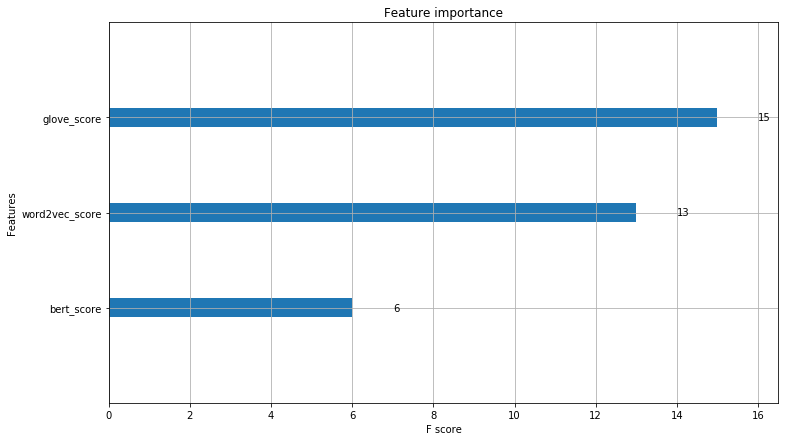

In [26]:
print('Accuracy Score : ' + str(accuracy_score(y_test,preds)))
print('Precision Score : ' + str(precision_score(y_test,preds)))
print('Recall Score : ' + str(recall_score(y_test,preds)))
print('F1 Score : ' + str(f1_score(y_test,preds)))
plt.rcParams['figure.figsize'] = [12, 7]
xgb.plot_importance(xg_class)

In [ ]:
# df = pd.DataFrame(preds)
# final = df.to_csv('csv/xgboost.csv')
# df.head()

In [ ]:
# params = {
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.2, 0.3, 0.4],
#         'max_depth': [10, 15, 20]
#         }
# grid_acc = GridSearchCV(xg_reg, param_grid = params)
# grid_acc.fit(X_train, y_train)
# y_pred_acc = grid_acc.predict(X_test)

# # New Model Evaluation metrics 
# print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc.round())))
# print('Precision Score : ' + str(precision_score(y_test,y_pred_acc.round())))
# print('Recall Score : ' + str(recall_score(y_test,y_pred_acc.round())))
# print('F1 Score : ' + str(f1_score(y_test,y_pred_acc.round())))

#### RandomForest

In [27]:
rf_model = RandomForestClassifier(random_state=13, n_estimators=5, max_depth=10)
rf_model.fit(X_train, y_train)
preds = rf_model.predict(X_test)

print('Accuracy Score : ' + str(accuracy_score(y_test,preds)))
print('Precision Score : ' + str(precision_score(y_test,preds)))
print('Recall Score : ' + str(recall_score(y_test,preds)))
print('F1 Score : ' + str(f1_score(y_test,preds)))

Accuracy Score : 0.9378283712784589
Precision Score : 0.9350104821802935
Recall Score : 0.9176954732510288
F1 Score : 0.9262720664589824


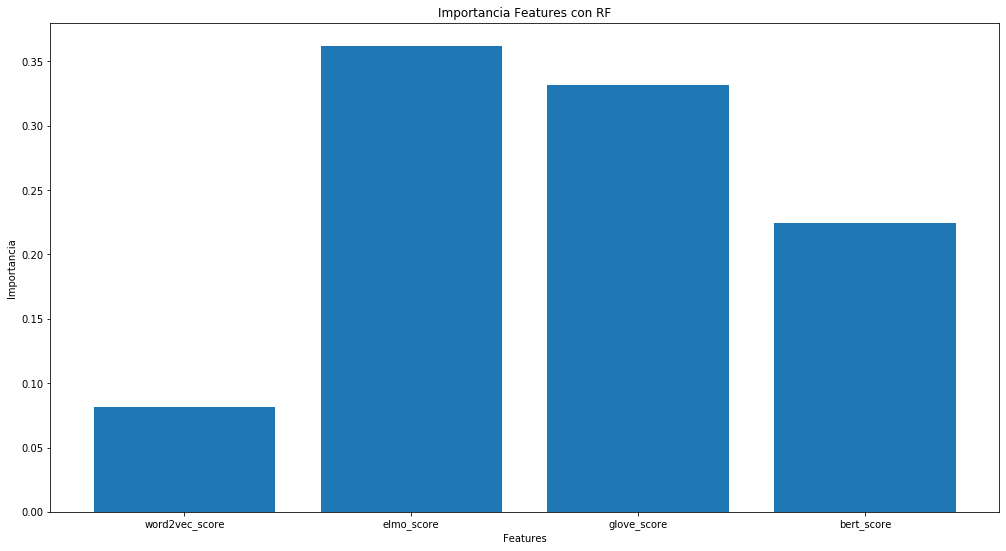

In [28]:
rf_model.feature_importances_
plt.figure(figsize=(17,9))
plt.bar(X_train.columns, rf_model.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Importancia Features con RF')
plt.show()

In [ ]:
# df = pd.DataFrame(preds)
# final = df.to_csv('csv/randomForest.csv')
# df.head()

rf_model.feature_importances_
plt.figure(figsize=(17,9))
plt.bar(X_train.columns, rf_model.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Importancia Features con RF')
plt.show()

#### LightGBM

In [29]:
lgb_class = lgb.LGBMClassifier(learning_rate = 0.1,
                max_depth = 10, alpha = 10, n_estimators = 5)
lgb_class.fit(X_train, y_train)
preds = lgb_class.predict(X_test)

print('Accuracy Score : ' + str(accuracy_score(y_test,preds)))
print('Precision Score : ' + str(precision_score(y_test,preds)))
print('Recall Score : ' + str(recall_score(y_test,preds)))
print('F1 Score : ' + str(f1_score(y_test,preds)))

Accuracy Score : 0.946584938704028
Precision Score : 0.958963282937365
Recall Score : 0.9135802469135802
F1 Score : 0.9357218124341411


In [ ]:
# df = pd.DataFrame(preds)
# final = df.to_csv('csv/lightgbm.csv')
# df.head()

#### CatBoost

In [30]:
catb = CatBoostClassifier(iterations=5)
catb.fit(X_train, y_train)
preds = catb.predict(X_test)

print('Accuracy Score : ' + str(accuracy_score(y_test,preds)))
print('Precision Score : ' + str(precision_score(y_test,preds)))
print('Recall Score : ' + str(recall_score(y_test,preds)))
print('F1 Score : ' + str(f1_score(y_test,preds)))

Learning rate set to 0.5
0:	learn: 0.4007872	total: 63.2ms	remaining: 253ms
1:	learn: 0.2834393	total: 104ms	remaining: 157ms
2:	learn: 0.2242532	total: 141ms	remaining: 93.9ms
3:	learn: 0.1933063	total: 163ms	remaining: 40.8ms
4:	learn: 0.1767549	total: 186ms	remaining: 0us
Accuracy Score : 0.9439579684763573
Precision Score : 0.9470338983050848
Recall Score : 0.9197530864197531
F1 Score : 0.9331941544885177


In [ ]:
# df = pd.DataFrame(preds)
# final = df.to_csv('csv/catboost.csv')
# df.head()

#### GradientBoosting

In [31]:
gb = GradientBoostingClassifier(n_estimators=5, learning_rate=0.1, 
                                max_features=2, max_depth = 2, random_state = 0)
gb.fit(X_train, y_train)
preds = gb.predict(X_test)

print('Accuracy Score : ' + str(accuracy_score(y_test,preds.round())))
print('Precision Score : ' + str(precision_score(y_test,preds.round())))
print('Recall Score : ' + str(recall_score(y_test,preds.round())))
print('F1 Score : ' + str(f1_score(y_test,preds.round())))

Accuracy Score : 0.9430823117338003
Precision Score : 0.9507494646680942
Recall Score : 0.9135802469135802
F1 Score : 0.9317943336831059


In [ ]:
# df = pd.DataFrame(preds)
# final = df.to_csv('csv/logicRegression.csv')
# df.head()

#### Majority voting

In [32]:
eclf2 = VotingClassifier(estimators=[
         ('xgb', xg_class), ('rf', rf_model), ('catb', catb), ('gb', gb), ('lgbm',lgb_class)])

In [33]:
eclf2 = eclf2.fit(X, y)

Learning rate set to 0.5
0:	learn: 0.3949619	total: 9.85ms	remaining: 39.4ms
1:	learn: 0.2804011	total: 50ms	remaining: 74.9ms
2:	learn: 0.2253661	total: 73.1ms	remaining: 48.7ms
3:	learn: 0.1922623	total: 89.8ms	remaining: 22.5ms
4:	learn: 0.1762006	total: 125ms	remaining: 0us


In [34]:
preds = eclf2.predict(X_test)

print('Accuracy Score : ' + str(accuracy_score(y_test,preds)))
print('Precision Score : ' + str(precision_score(y_test,preds)))
print('Recall Score : ' + str(recall_score(y_test,preds)))
print('F1 Score : ' + str(f1_score(y_test,preds)))

Accuracy Score : 0.9492119089316988
Precision Score : 0.9572649572649573
Recall Score : 0.9218106995884774
F1 Score : 0.939203354297694


### Predicciones

In [35]:
test['target'] = eclf2.predict(test.iloc[:,:]).astype(int)

In [36]:
test.drop(columns=['word2vec_score','elmo_score','glove_score','bert_score'], inplace=True)
test.head()

,bert_score,target
id,,
0,0.439007,1
2,0.499864,1
3,0.473253,1
9,0.708013,1
11,0.621354,1


In [37]:
test.drop(columns=['bert_score'], inplace=True)
test.head()

,target
id,
0,1
2,1
3,1
9,1
11,1


In [38]:
final = test.to_csv('csv/submission_modelo10_voting.csv')